# Kalman Filter for Intestinal Microbiota

## Models:

### Basics:

In a basic Kalman Filter model, the graphical model is defined as follows:

for all $t$, $z_{t} \in \mathbb{R}^{dimension}, u_{t} \in \mathbb{R}^{control dimension}$

$z_{0} \sim \mathbb{N}(\hat{\mu_{0}}, \hat{P_{0}})$

for $t$ in [1, $T$]:

$\quad z_{t} = Az_{t - 1} + Bu_{t - 1} + \mathbb{N}(0, Q)$

$\quad x_{t} = z_{t} + \mathbb{N}(0, R)$ (if $x_{t}$ is observed)

### Multiple Sequence Kalman Filter

Since we measure intestinal microbiota in different patients, there are multiple sequences representing the microbiota dynamics in different patients. We introduce a new subscript $s$. Suppose the time of observation of $s^{th}$ patient is $T_{s}$, then we have:

for $s$ in $S$:

$\quad z_{s,0} \sim \mathbb{N}(\hat{\mu_{0}}, \hat{P_{0}})$

$\quad$ for $t$ in [1, $T_{s}$]:

$\quad \quad z_{s,t} = Az_{s,t - 1} + Bu_{s,t - 1} + \mathbb{N}(0, Q)$

$\quad \quad x_{s,t} = z_{s,t} + \mathbb{N}(0, R)$ (if $x_{s,t}$ is observed)

## Example Code

In [1]:
import numpy as np
from Kalman_Filter import Kalman_Filter
from Kalman_Filter_API import simulate, calculate_log_likelihood
from Utils import apply_mask
import matplotlib.pyplot as plt
from EM_Config import EM_Config

In [2]:
dimension = 2
seq_count = 100
seq_length = 5
control_dimension = 2
np.random.seed(1)

In [3]:
# the control matrix
U = np.ones(shape=(seq_count, seq_length, control_dimension))

# setting simulating parameters
missing_proportion = 0.1
z_0_hat = np.zeros(dimension)
P_0_hat = 0.5 * np.eye(dimension)
A = np.eye(dimension)
B = np.random.random(size=(dimension, control_dimension))
Q = 0.5 * np.eye(dimension)
R = 0.5 * np.eye(dimension)
parameters = (z_0_hat, P_0_hat, A, B, Q, R)
Z, X = simulate(U, parameters)
mask = np.random.random(size=(seq_count, seq_length)) > missing_proportion
apply_mask(X, mask)

In [4]:
print(U[0])
print(X[0])

[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]
[array([ 0.23846178, -2.38613701]), array([ 2.22323561, -1.17084249]), array([ 3.94087044, -2.42037096]), array([ 5.98597124, -3.24483679]), array([ 6.49683724, -1.10009571])]


$X$ is an array (of length $S$) of array (of length $S_{t}$) of measurements $x_{s,t}$; if the measurement is missing, its value is None.

$U$ is an array (of length $S$) of array (of length $T_{s}$) of control vectors $u_{s,t}$. Different sequences can have different length.

EM Iteration 5: log likelihood=-3.00846
EM Iteration 10: log likelihood=-3.00264
EM Iteration 15: log likelihood=-3.00047
EM Iteration 20: log likelihood=-2.99909
EM Iteration 25: log likelihood=-2.99822
EM Iteration 30: log likelihood=-2.99770
EM Iteration 35: log likelihood=-2.99739
EM Iteration 40: log likelihood=-2.99720
EM Iteration 45: log likelihood=-2.99708
EM Iteration 50: log likelihood=-2.99701
At iteration 52 EM stops, log likelihood -2.99699


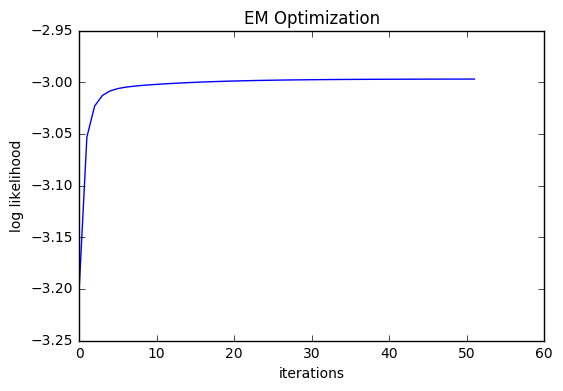

In [5]:
# initialize the Kalman Filter
kf = Kalman_Filter(dimension, control_dimension)

# train the parameters on all but the last sequence
kf.fit(X[:-1], U[:-1], print_every=5)

# plot the log likelihood against training iterations
plt.plot(kf.ll_history)
plt.title('EM Optimization')
plt.xlabel('iterations')
plt.ylabel('log likelihood')

plt.show()

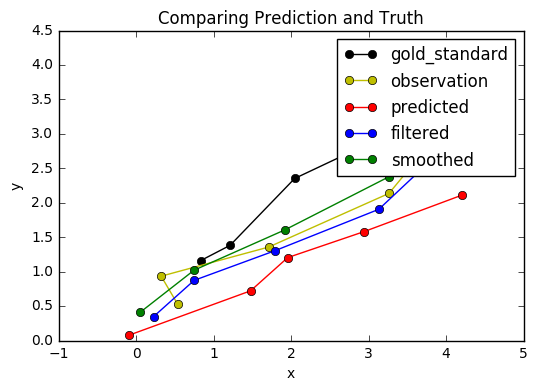

In [6]:
# test on the last sequence
predicted, filtered, smoothed = kf.estimate(X[-1:], U[-1:])
ground_truth = np.array(Z[-1])
measured_seq = np.array([x for x in X[-1] if x is not None])
predicted_seq = np.array(predicted['mean'][-1])
filtered_seq = np.array(filtered['mean'][-1])
smoothed_seq = np.array(smoothed['mean'][-1])
plt.clf()
plt.title('Comparing Prediction and Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(ground_truth[:,0], ground_truth[:,1], '-ko', label='gold_standard')
plt.plot(measured_seq[:,0], measured_seq[:,1], '-yo', label='observation')
plt.plot(predicted_seq[:,0], predicted_seq[:,1], '-ro', label='predicted')
plt.plot(filtered_seq[:,0], filtered_seq[:,1], '-bo', label='filtered')
plt.plot(smoothed_seq[:,0], smoothed_seq[:,1], '-go', label='smoothed')
plt.legend()
plt.show()

The returned value of estimate is a tuple: predicted, filtered, smoothed; all of them are well defined values in the algorithm. Since each of the hidden variable has a posterior of Normal distribution, predicted['mean'] is an array of array of mean of the posterior (of $z_{s,t}$) and predicted['covariance'] is an array of array of the covariance of the posterior of $z_{s,t}$. Same for filtered and smoothed return values

It also supports calculating log likelihood

In [7]:
print(calculate_log_likelihood(X[:-1], U[:-1], kf.parameters))

-2.99698212615


### What's More - Flexible EM Options

Besides providing inference for $B$ matrix and for multiple sequences, functionalities not implemented in other packages, it also implements a very flexible set of EM operations. We can set the initial value of the parameters and the update constraint on the covariance matrices

In [8]:
# initialize the Kalman 
kf = Kalman_Filter(dimension, control_dimension)
EM_Config.print_em_manual()

# config the EM step
kf.config['A_option'] = 'fixed'
kf.config['Q_option'] = 'scalar'
kf.config['R_option'] = 'diag'
kf.config['num_iterations'] = 10
kf.config['threshold'] = 1e-7
kf.config['initial_B'] = np.random.random(size=(dimension, control_dimension))

------------ EM_Config Manual ------------
The list of keys for the configuration
['z_0_hat_option', 'initial_z_0_hat', 'P_0_hat_option', 'initial_P_0_hat', 'AB_option', 'initial_A', 'initial_B', 'Q_option', 'initial_Q', 'R_option', 'initial_R', 'threshold', 'num_iterations']

--- Option explanations ---
<parameter_name>_options available choices
['fixed', 'flexible', 'diag', 'scalar']
fixed: fix the parameter during training time
flexible: no constraint during traning time
diag: keep the parameter a diagnol matrix, only available for P_0_hat, Q, R
scalar: keep the parameter a scalar time identity matrix, only available for P_0_hat, Q, R
--- Option explanations ---

initial_<parameter_name> is the initial value of the EM algorithm for <parameter_name>

--- Stopping Criteria ---
threshold: considered converge whenever the improvement of log likelihood is less than threshold
num_iterations: perform EM algorithm of num_iterations
stop whenever either criteria is reached
--- Stopping Crite

EM Iteration 1: log likelihood=-3.26621
EM Iteration 2: log likelihood=-3.10189
EM Iteration 3: log likelihood=-3.05344
EM Iteration 4: log likelihood=-3.03094
EM Iteration 5: log likelihood=-3.01981
EM Iteration 6: log likelihood=-3.01435
EM Iteration 7: log likelihood=-3.01163
EM Iteration 8: log likelihood=-3.01020
EM Iteration 9: log likelihood=-3.00934
EM Iteration 10: log likelihood=-3.00876
At iteration 10 EM stops, log likelihood -3.00876


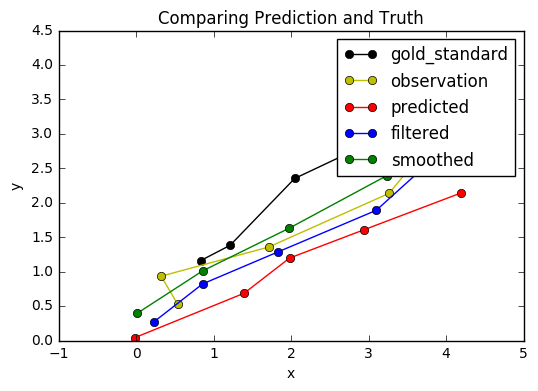

In [9]:
kf.fit(X[:-1], U[:-1], print_every=1)
predicted, filtered, smoothed = kf.estimate(X[-1:], U[-1:])
ground_truth = np.array(Z[-1])
measured_seq = np.array([x for x in X[-1] if x is not None])
predicted_seq = np.array(predicted['mean'][-1])
filtered_seq = np.array(filtered['mean'][-1])
smoothed_seq = np.array(smoothed['mean'][-1])
plt.clf()
plt.title('Comparing Prediction and Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(ground_truth[:,0], ground_truth[:,1], '-ko', label='gold_standard')
plt.plot(measured_seq[:,0], measured_seq[:,1], '-yo', label='observation')
plt.plot(predicted_seq[:,0], predicted_seq[:,1], '-ro', label='predicted')
plt.plot(filtered_seq[:,0], filtered_seq[:,1], '-bo', label='filtered')
plt.plot(smoothed_seq[:,0], smoothed_seq[:,1], '-go', label='smoothed')
plt.legend()
plt.show()

In [10]:
z_0_hat, P_0_hat, A, B, Q, R = kf.parameters

In [11]:
print('Covariance matrix P_0_hat is updated without any constraint')
print(P_0_hat)

Covariance matrix P_0_hat is updated without any constraint
[[ 0.43553884  0.07574194]
 [ 0.07574194  0.40210876]]


In [12]:
print('Covariance matrix Q is updated with the constraint of being a scalar times identity')
print(Q)

Covariance matrix Q is updated with the constraint of being a scalar times identity
[[ 0.34217817  0.        ]
 [ 0.          0.34217817]]


In [13]:
print('Covariance matrix R is updated with the constraint of being diagnol')
print(R)

Covariance matrix R is updated with the constraint of being diagnol
[[ 0.61068921  0.        ]
 [ 0.          0.51103047]]


## The parsing APIs

### Parse otu table file

In [14]:
from Parse_Utils import read_otu_table, read_event, map_2D_array, inverse_SPIEC,\
    pick_topk, extract_event_by_type, default_measurement_transformation, or_U

In [15]:
otuTable_file = '../data/otuTable.tsv'

# read the otuTable file, cluster by genus
print('Reading the otuTable: ')
measurements, bacteria2idx, idx2bacteria, id2start_date, id2end_date = read_otu_table(otuTable_file)
print('Measurement of first patient on first day, showing only the top 20 dimensions')
print(measurements[0][0][:20])
print('The bacteria (cluster, default: genus) each dimension corresponds to')
print([idx2bacteria[idx] for idx in range(20)])

Reading the otuTable: 
Measurement of first patient on first day, showing only the top 20 dimensions
[  0  17   1 602   0   0   0  79 210 290 184   1   0  55   1   0  29   0
  25  10]
The bacteria (cluster, default: genus) each dimension corresponds to
['Enterococcus', 'Streptococcus', 'Lactobacillus', 'Blautia', 'Staphylococcus', 'Escherichia/Shigella', 'Bacteroides', 'unclassified', 'Coprobacillus', 'Dorea', 'Sporacetigenium', 'Lactococcus', 'Akkermansia', 'Roseburia', 'Granulicatella', 'Klebsiella', 'unclassified_Lachnospiraceae', 'Veillonella', 'Clostridium', 'Subdoligranulum']


In [16]:
# pick the top 10 clusters (in addition to "includes")
# exclude "Streptococcocus", include "Subdoligranulum"
# add all non-selected clusters to the "other" cluster
print('Picking the top clusters: ')
measurements, idx2bacteria = pick_topk(measurements, idx2bacteria, k=10, includes=["Subdoligranulum"], 
                            excludes=['Streptococcus'], include_other=True)
print('Measurement of the top clusters')
print(measurements[0][0])
print('The bacteria (cluster, default: genus) each dimension corresponds to')
print(idx2bacteria)

Picking the top clusters: 
Measurement of the top clusters
[  0 602   0   1 290  79   0 210   0  29  10 756]
The bacteria (cluster, default: genus) each dimension corresponds to
['Enterococcus', 'Blautia', 'Bacteroides', 'Lactobacillus', 'Dorea', 'unclassified', 'Staphylococcus', 'Coprobacillus', 'Escherichia/Shigella', 'unclassified_Lachnospiraceae', 'Subdoligranulum', 'OTHER']


In [17]:
# apply the default SPIEC transform
measurements = default_measurement_transformation(measurements)
print('After the SPIEC transform: ')
print(measurements[0][0])

After the SPIEC transform: 
[-2.91089403  3.49102317 -2.91089403 -2.21774685  2.76242924  1.47113261
 -2.91089403  2.44096411 -2.91089403  0.49030335 -0.51299875]


### Parse event file

In [18]:
event_file = '../data/events.tsv'

# read the event table
print('Reading the event table')
U, event_name2idx, idx2event_name = read_event(event_file, id2start_date, id2end_date)
print('one-hot encoded events of 1st patient on the 1st day')
print(U[0][0])
print(idx2event_name)

Reading the event table
one-hot encoded events of 1st patient on the 1st day
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
{0: ('Antibiotic', 'Fluoroquinolone'), 1: ('Antibiotic', 'Vancomycin'), 2: ('Antibiotic', 'Beta-lactam'), 3: ('Antibiotic', 'Metronidazole'), 4: ('Bacteremia', 'Klebsiella pneumoniae'), 5: ('Bacteremia', 'Pseudomonas aeruginosa, CNST, VSE'), 6: ('Bacteremia', 'Pseudomonas aeruginosa'), 7: ('Bacteremia', 'VRE'), 8: ('Bacteremia', 'Klebsiella oxytoca'), 9: ('Bacteremia', 'VRE/VSE'), 10: ('Antibiotic', 'PO-Vanco'), 11: ('Bacteremia', 'E. coli'), 12: ('Bacteremia', 'Fusobacterium species'), 13: ('Bacteremia', 'Leptotrichia trevisanii'), 14: ('Bacteremia', 'VSE'), 15: ('Bacteremia', 'CNST'), 16: ('Bacteremia', 'Enterobacter agglomerans'), 17: ('Bacteremia', 'MRSA'), 18: ('Bacteremia', 'MRSA, MDR Pseudomonas aeruginosa'), 19: ('Bacteremia', 'Neisseria species, non-pathogenic'), 20: ('Bacteremia', 'Stenotrophomonas 

In [19]:
print('Extract the antibiotic administration history of the patient')
antibiotic_history, antibiotic_dict =  extract_event_by_type(U, idx2event_name, 'Antibiotic')
print('The antibiotic administration history of the 1st patient on the 1st day')
print(antibiotic_history[0][0])
print('The antibiotic type each dimension corresponds to')
print(antibiotic_dict)

Extract the antibiotic administration history of the patient
The antibiotic administration history of the 1st patient on the 1st day
[ 0.  1.  0.  0.  0.]
The antibiotic type each dimension corresponds to
{0: ('Antibiotic', 'Fluoroquinolone'), 1: ('Antibiotic', 'Vancomycin'), 2: ('Antibiotic', 'Beta-lactam'), 3: ('Antibiotic', 'Metronidazole'), 4: ('Antibiotic', 'PO-Vanco')}


In [20]:
print('Extract the bacteremia history of the patient')
print('The bacteremia history of the 41st patient on the 10th day')
bacteremia_history, bacteremia_dict = extract_event_by_type(U, idx2event_name, 'Bacteremia')
print(bacteremia_history[40][9])
print('The bacteremia type each dimension corresponds to')
print(bacteremia_dict)

Extract the bacteremia history of the patient
The bacteremia history of the 41st patient on the 10th day
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
The bacteremia type each dimension corresponds to
{0: ('Bacteremia', 'Klebsiella pneumoniae'), 1: ('Bacteremia', 'Pseudomonas aeruginosa, CNST, VSE'), 2: ('Bacteremia', 'Pseudomonas aeruginosa'), 3: ('Bacteremia', 'VRE'), 4: ('Bacteremia', 'Klebsiella oxytoca'), 5: ('Bacteremia', 'VRE/VSE'), 6: ('Bacteremia', 'E. coli'), 7: ('Bacteremia', 'Fusobacterium species'), 8: ('Bacteremia', 'Leptotrichia trevisanii'), 9: ('Bacteremia', 'VSE'), 10: ('Bacteremia', 'CNST'), 11: ('Bacteremia', 'Enterobacter agglomerans'), 12: ('Bacteremia', 'MRSA'), 13: ('Bacteremia', 'MRSA, MDR Pseudomonas aeruginosa'), 14: ('Bacteremia', 'Neisseria species, non-pathogenic'), 15: ('Bacteremia', 'Stenotrophomonas maltophilia'), 16: ('Bacteremia', 'Serratia marcescens'), 17: ('Bacteremia', 'ESBL E.coli'), 18: ('Bacteremia', 'Entero

In [21]:
print('Whether the patient contracts any kind of bacteremia')
print('A day by day record of whether the 76th patient has contracted bacteremia')
any_bacteremia_history = or_U(bacteremia_history)
print(any_bacteremia_history[75])

Whether the patient contracts any kind of bacteremia
A day by day record of whether the 76th patient has contracted bacteremia
[False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False]


## Apply Kalman Filter to Microbiota

In [ ]:
# under the SPIEC transform, the dimension of measurements is fewer by 1
dimension, control_dimension = len(idx2bacteria) - 1, len(antibiotic_dict)
kf = Kalman_Filter(dimension, control_dimension)
kf.config['Q_option'] = 'diag'
kf.config['R_option'] = 'diag'
kf.config['P_0_hat_option'] = 'diag'
kf.config['threshold'] = 1e-4

In [ ]:
print('Traning')
kf.fit(measurements, antibiotic_history, print_every=50)
plt.plot(kf.ll_history)
plt.title('EM Optimization')
plt.xlabel('iterations')
plt.ylabel('log likelihood')
plt.show()

Traning


In [ ]:
predicted, filtered, smoothed = kf.estimate(measurements, antibiotic_history)
filtered_mean = filtered['mean']
filtered_frequency = map_2D_array(filtered_mean, inverse_SPIEC)
print('The filtered microbiota(frequency) of the 1st patient on the 1st day')
print(filtered_frequency[0][0])